### Analyse der Wortfrequenzen in BVG-Pressemitteilungen

In diesem Notebook erfolgt eine quantitativ-explorative Analyse der Wortfrequenzen in den Pressemitteilungen der BVG.  
Ziel ist es, einen ersten Überblick darüber zu gewinnen, welche Begriffe besonders häufig verwendet werden, insgesamt und im Zeitverlauf.

Die bereinigte Wortfrequenztabelle wird als CSV-Datei gespeichert und bildet die Grundlage für die nachgelagerte Clusteranalyse.

Visualisiert und untersucht werden:
- Häufigste Begriffe über alle Jahre
- Top-Begriffe pro Jahr
- Verteilung der Begriffe in Word Clouds

#### 1. Import benötigte Pakete

In [104]:
# Standard
import os  # Arbeiten mit Dateipfaden
import pandas as pd  # Tabellenverarbeitung (DataFrames)

# Automatisierte Datenübersicht
from ydata_profiling import ProfileReport

# Visualisierung & Textanalyse
from wordcloud import WordCloud  # Word Clouds erzeugen
import matplotlib.pyplot as plt  # Diagramme zeichnen
import numpy as np  # Visualisierung

##### 1.1 Interaktives Plotting aktivieren

In [105]:
%matplotlib inline

In [106]:
# Pfade
# Projektverzeichnis 
PROJECT_ROOT = r"D:/DBU/ADSC11 ADS-01/Studienarbeit/newspaper-scraping"

# Eingabedaten: CSV-Datei mit Pressetexten
DATAPATH = os.path.join(PROJECT_ROOT, "output", "pm_bvg_clean.csv")

# Output 
OUTPUT_PATH = os.path.join(PROJECT_ROOT, "output")
CSV_PATH = os.path.join(OUTPUT_PATH, "pm_bvg_clean_final.csv")

#### 2. Datenexploration

In [107]:
# CSV-Datei einlesen 
df_bvg = pd.read_csv(DATAPATH)

In [108]:
# Überblick df_pm
df_bvg.head()

,count,word,file_name,source,date
0,8,biesdorf,13-points-go-to.html,bvg_pm,2021-08-06
1,4,berliner,13-points-go-to.html,bvg_pm,2021-08-06
2,3,mobilität,13-points-go-to.html,bvg_pm,2021-08-06
3,3,berlin,13-points-go-to.html,bvg_pm,2021-08-06
4,2,sharing-angebote,13-points-go-to.html,bvg_pm,2021-08-06


In [109]:
# Anzahl Zeilen und Spalten
df_bvg.shape

(54291, 5)

In [110]:
# Übersicht Daten
# Data profiling 
profile = ProfileReport(df_bvg)

# Pfad
profile_path = os.path.join(OUTPUT_PATH, "pressetext_bvg_profile_report.html")

# HTML-Export
profile.to_file(profile_path)

print(f"[INFO] Report gespeichert unter: {profile_path}")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  4.76it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Report gespeichert unter: D:/DBU/ADSC11 ADS-01/Studienarbeit/newspaper-scraping\output\pressetext_bvg_profile_report.html


In [111]:
# Zeitraum 
df_bvg["date"] = pd.to_datetime(df_bvg["date"])  

print("Zeitraum:")
print("Von:", df_bvg["date"].min().date())
print("Bis:", df_bvg["date"].max().date())

Zeitraum:
Von: 2021-04-01
Bis: 2025-04-28


In [112]:
# Fehlende Werte 
df_bvg.isna().sum()

count        0
word         0
file_name    0
source       0
date         0
dtype: int64

#### 3. Analyse der Wortfrequenzen

##### 3.1 Vorbereitung der Analyse

In [113]:
# Top-Wörter
df_bvg_top = (
    df_bvg.groupby("word")["count"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .head(10)
)

print(df_bvg_top)

               word  count
0               bvg   1240
1          berliner    522
2            berlin    328
3         fahrgäste    298
4             linie    291
5               uhr    257
6            straße    218
7  verkehrsbetriebe    199
8           werden.    199
9         u-bahnhof    196


In [114]:
# Kopie von df_bvg für die weitere Analyse
df_bvg_clean = df_bvg.copy()

In [115]:
# Wordcloud Vorbereitung (1): Für die Analyse nicht relevante Wörter ausschließen 
monate = ["januar", "februar", "märz", "april", "mai", "juni", "juli", "august", "september", "oktober", "november", "dezember"]
wochentage = ["montag", "dienstag", "mittwoch", "donnerstag", "freitag", "samstag", "sonntag"]
jahre = ["2021", "2022", "2023", "2024", "2025"]
weitere_ausnahmen = ["cookie-einstellungen", "z.b", "ip-adresse", "ipadresse", "cookieeinstellungen"]  # individuell definierte Störwörter

# Gesamt Ausschlussliste
ausschluss_wörter = set(monate + wochentage + jahre + weitere_ausnahmen)

# Sonderzeichen bereinigen 
df_bvg_clean["word"] = df_bvg_clean["word"].str.lower().str.replace(r"[^\wäöüß]", "", regex=True)

# Fehlende Werte, leere Strings und 1-Buchstaben-Wörter entfernen
df_bvg_clean = df_bvg_clean[
    df_bvg_clean["word"].notna() &
    (df_bvg_clean["word"].str.len() > 1)
]

# Ausschlussfilter anwenden
df_bvg_clean = df_bvg_clean[
    ~df_bvg_clean["word"].isin(ausschluss_wörter) &
    ~df_bvg_clean["word"].str.fullmatch(r"\d+")
]

In [116]:
# Als CSV-Datei exportieren für die Clusteranalyse
df_bvg_clean.to_csv(CSV_PATH, index=False, encoding="utf-8")

In [117]:
# Wordcloud Vorbereitung (2): Farben: BVG-Farbpalette, Farben nach Top-Words
color_map = {
    "1-10": "#FDD722", # Gelb
    "11-20": "#989B9A", # Verkehrs-Grau A
    "21-30": "#595B62", # Schiefergrau
    "31-50": "#252525", # Schwarz
}

In [118]:
# Wordcloud Vorbereitung (3): Wortfrequenzen berechnen
word_freq = df_bvg_clean.groupby("word")["count"].sum().to_dict()

# Top 50 Wörter sortieren
top_words_sorted = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
word_to_color = {}

for i, (word, _) in enumerate(top_words_sorted):
    if i < 10:
        word_to_color[word] = color_map["1-10"]
    elif i < 20:
        word_to_color[word] = color_map["11-20"]
    elif i < 30:
        word_to_color[word] = color_map["21-30"]
    elif i < 50:
        word_to_color[word] = color_map["31-50"]

# Weitere Farben für übrige Wörter 
fallback_colors = ["#BFBFBF", "#DADADA", "#EAEAEA"]

# Funktion für Farbauswahl
def color_func(word, **kwargs):
    return word_to_color.get(word, np.random.choice(fallback_colors))

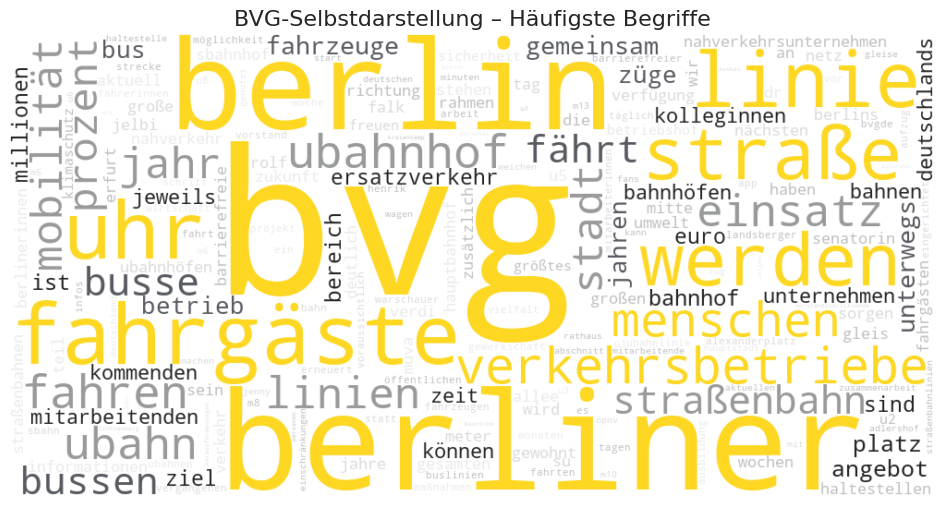

In [119]:
# Wordcloud erstellen
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color="white",
    color_func=color_func
).generate_from_frequencies(word_freq)

# Plot Formatierung: Titel, Achsen, Layout 
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("BVG-Selbstdarstellung – Häufigste Begriffe", fontsize=16, color="#252525")
plt.show()

In [120]:
# Top Wörter nach Jahren: Vorbereitung
# Jahr ergänzen
df_bvg_clean["year"] = pd.to_datetime(df_bvg_clean["date"]).dt.year

# Gruppieren
top_words_by_year = (
    df_bvg_clean.groupby(["year", "word"])["count"]
    .sum()
    .reset_index()
)

# Top 10 pro Jahr ausgeben
for year in sorted(top_words_by_year["year"].dropna().unique()):
    print(f"\nTop-Wörter im Jahr {int(year)}:")
    top_words = (
        top_words_by_year[top_words_by_year["year"] == year]
        .sort_values("count", ascending=False)
        .head(10)
    )
    print(top_words[["word", "count"]].to_string(index=False))


Top-Wörter im Jahr 2021:
            word  count
             bvg    215
        berliner    116
             uhr    113
           linie     97
          straße     90
          berlin     84
       fahrgäste     73
        ubahnhof     67
verkehrsbetriebe     53
          werden     50

Top-Wörter im Jahr 2022:
            word  count
             bvg    371
        berliner    166
          straße    119
           linie    117
          berlin    103
             uhr    101
       fahrgäste     88
          fahren     81
verkehrsbetriebe     80
        ubahnhof     75

Top-Wörter im Jahr 2023:
            word  count
             bvg    307
        berliner     89
          berlin     85
             uhr     58
       fahrgäste     54
          werden     51
          straße     51
verkehrsbetriebe     48
           linie     47
          fahren     45

Top-Wörter im Jahr 2024:
     word  count
      bvg    438
   berlin    127
 berliner    122
fahrgäste     97
    ubahn     76
 m

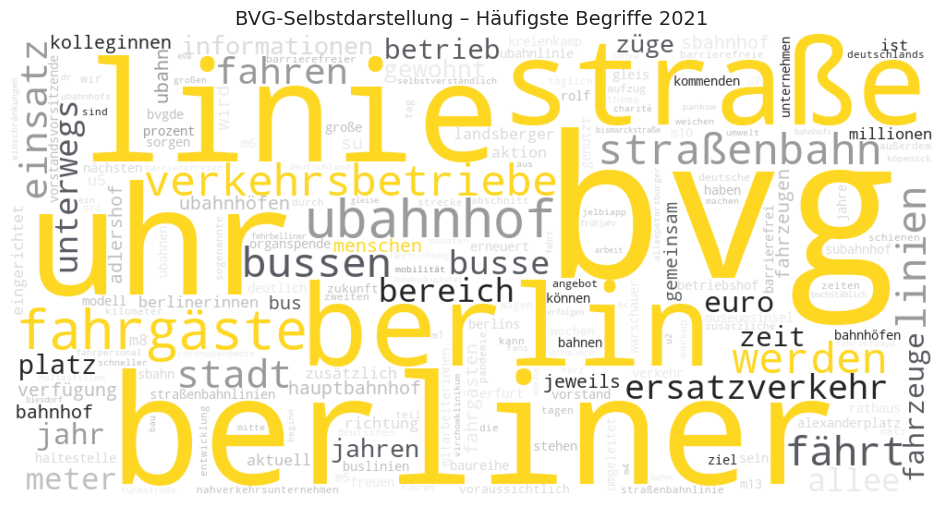

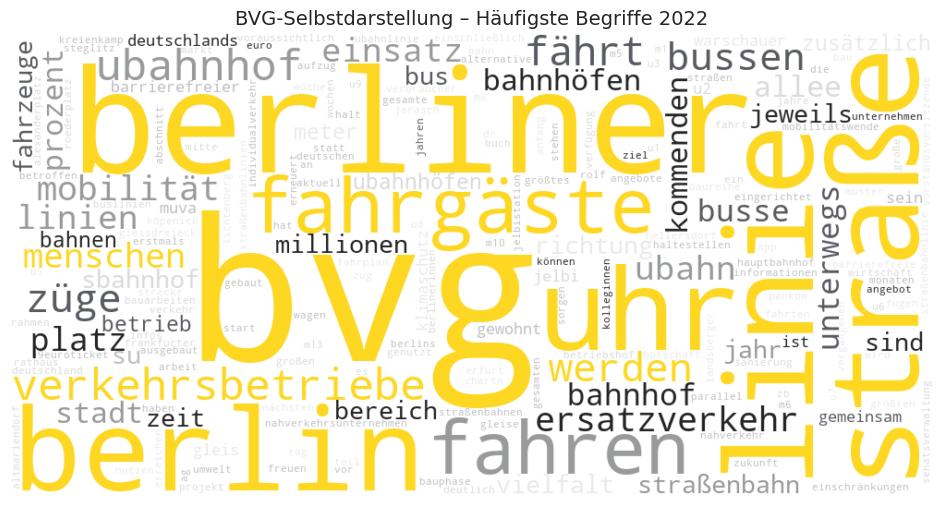

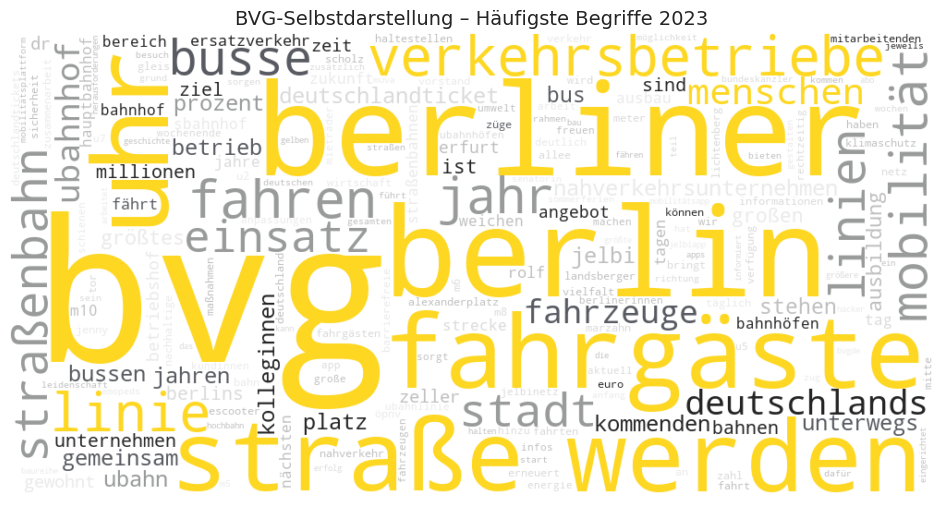

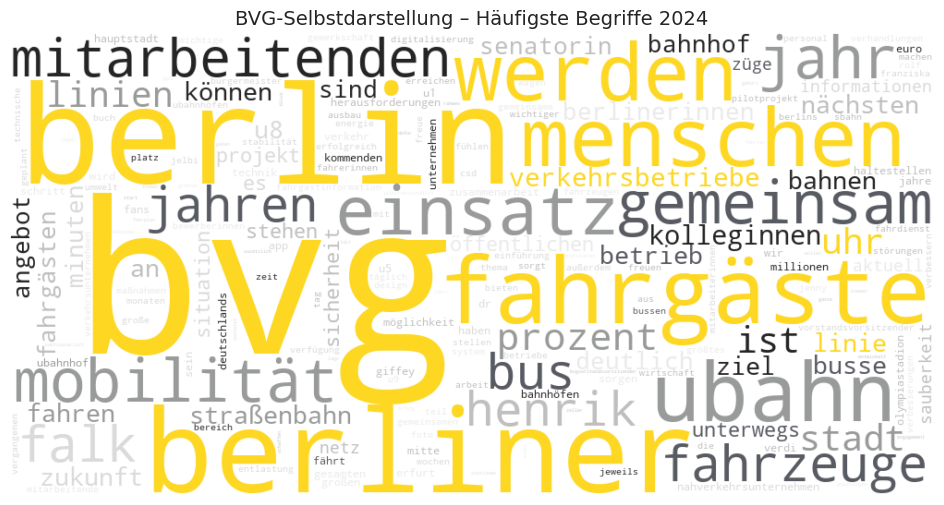

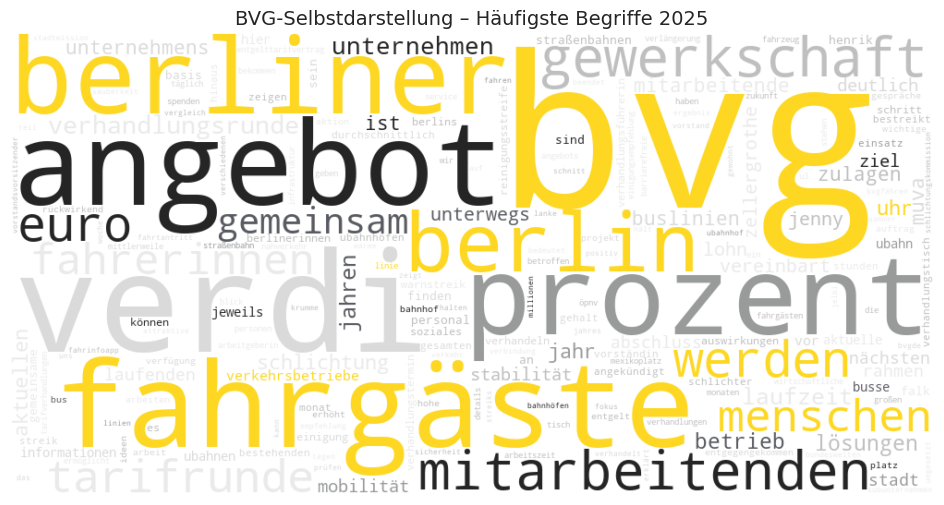

In [121]:
# Top Wörter nach Jahren: Plott
# Alle Jahre im Datensatz 
years = sorted(df_bvg_clean["year"].unique())

# Wordcloud je Jahr
for year in years:
    year_data = df_bvg_clean[df_bvg_clean["year"] == year]  
    word_freq = year_data.groupby("word")["count"].sum().to_dict()

    wc = WordCloud(
        width=1000,
        height=500,
        background_color="white",
        color_func=color_func
    ).generate_from_frequencies(word_freq)

    # Plot Formatierung: Titel, Achsen, Layout 
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"BVG-Selbstdarstellung – Häufigste Begriffe {int(year)}", fontsize=14, color="#252525")
    plt.show()
